<a href="https://colab.research.google.com/github/GauravKumawat33/Recommendation_Project/blob/master/MRS_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset
! unzip -o -j movie-lens-small-latest-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
movie-lens-small-latest-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [ ]:
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.shape

(9742, 3)

In [ ]:
ratings.shape

(100836, 4)

In [ ]:
tags.shape

(3683, 4)

In [ ]:
# Preprocessing.

movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# use only the ratings given by the users who have rated atleast 55 movies --

ratings_f = ratings.groupby('userId').filter(lambda x : len(x) >= 55)

# list the movie titles that survive the filtering.

movie_list_rating = ratings_f['movieId'].unique().tolist()

In [ ]:
ratings_f.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
len(ratings_f['movieId'].unique()) / len(movies['movieId'].unique())

# so 97 % of the movies have been rated by the active users.

0.987990145760624

In [ ]:
len(ratings_f['userId'].unique()) / len(ratings['userId'].unique())

# so only 57% of users are active users.

0.5967213114754099

In [ ]:
# filtering the movies.

movies = movies[movies['movieId'].isin(movie_list_rating)]

movies.shape

(9625, 3)

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# mapping title to movieId

mapping_file = dict(zip(movies['title'].tolist(), movies['movieId'].tolist()))

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
ratings_f.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# drop the 'timestamp' col from both tags and ratings_f dataframes.

tags.drop(['timestamp'], axis=1, inplace=True)

ratings_f.drop(['timestamp'], axis=1, inplace=True)

In [ ]:
# merging the tags and movies df's on basis of movieId

merged_df = pd.merge(movies, tags, on='movieId', how='left')

merged_df.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [ ]:
# add all the tags of given by the different users to each movie.

merged_df.fillna("", inplace=True)

merged_df = pd.DataFrame(merged_df.groupby('movieId')['tag'].apply(lambda x : "%s " % ' '.join(x)))

final_df = pd.merge(movies, merged_df, on='movieId', how='left')

final_df['metadata'] = final_df[['tag', 'genres']].apply(lambda x : ' '.join(x), axis=1)

final_df.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children ...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game ...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


In [ ]:
final_df.shape

(9625, 5)

In [ ]:
final_df.loc[0, 'metadata']

'pixar pixar fun  Adventure Animation Children Comedy Fantasy'

## creating a content latent matrix from metadata.

## tf-idf vectorizer and trucated SVD

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_df['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final_df.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [ ]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


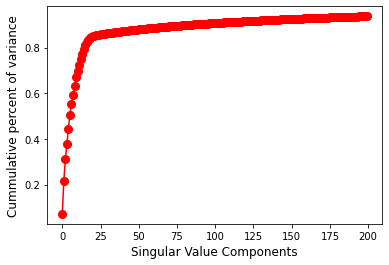

In [ ]:
# compress with SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)

latent_matrix = svd.fit_transform(tfidf_df)

# plot the variance to see what latent dimension to use

explained = svd.explained_variance_ratio_.cumsum()

plt.plot(explained, '.-', ms=16, color='red')

plt.xlabel('Singular Value Components', fontsize=12)

plt.ylabel('Cummulative percent of variance', fontsize=12)

plt.show()

In [ ]:
n = 200
latent_matrix_df = pd.DataFrame(latent_matrix[:, 0:n], index=final_df['title'].tolist())

In [ ]:
latent_matrix.shape

(9625, 200)

## creating collabortive latent matrix from user ratings

In [ ]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on='movieId', how='right')

In [ ]:
ratings_f2 = ratings_f1.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [ ]:
ratings_f2.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings_f2.shape

(9625, 364)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=final_df['title'].tolist())

In [ ]:
latent_matrix_2_df.shape

(9625, 200)

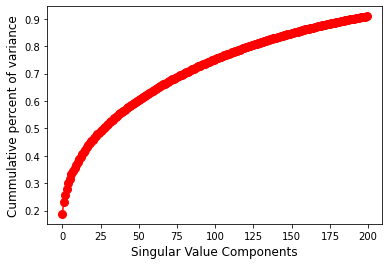

In [ ]:
# plot the variance to see what latent dimension to use

explained = svd.explained_variance_ratio_.cumsum()

plt.plot(explained, '.-', ms=16, color='red')

plt.xlabel('Singular Value Components', fontsize=12)

plt.ylabel('Cummulative percent of variance', fontsize=12)

plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_hybrid_recommendatin(movie):
  a_1=np.array(latent_matrix_df.loc[movie]).reshape(1,-1)
  a_2=np.array(latent_matrix_2_df.loc[movie]).reshape(1,-1)

  score_1=cosine_similarity(latent_matrix_df,a_1).reshape(-1)
  score_2=cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

  hybrid=((score_1+score_2)/2.0)

  dicDf={'content':score_1,'collaborative':score_2,'hybrid':hybrid}
  similar=pd.DataFrame(dicDf,index=latent_matrix_df.index)

  similar.sort_values('hybrid',ascending=False,inplace=True)
  return similar
# similar[1:].head(11)

In [ ]:
get_hybrid_recommendatin('Iron Man (2008)')[1:].head(11)

,content,collaborative,hybrid
X-Men: Days of Future Past (2014),1.000000,0.605044,0.802522
Avengers: Age of Ultron (2015),1.000000,0.526981,0.763491
Ant-Man (2015),1.000000,0.513989,0.756994
Deadpool (2016),0.953471,0.541542,0.747507
"Incredible Hulk, The (2008)",0.870177,0.624587,0.747382
"I, Robot (2004)",0.919409,0.570342,0.744876
Iron Man 2 (2010),0.731405,0.734776,0.733090
Star Wars: Episode I - The Phantom Menace (1999),0.999878,0.461844,0.730861
Indiana Jones and the Kingdom of the Crystal Skull (2008),0.953471,0.502322,0.727896
Star Trek Beyond (2016),1.000000,0.454544,0.727272
